<a href="https://colab.research.google.com/github/shaunhyp57/everglades/blob/master/analysis_everglades/first_player_tank_disband/first_tank_disband_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First Tank Disband: Experiment 2

### Predict winner of game based the following features:
* Player 0 score (Random Action)
* Player 1 score (Random Action)
* Player with First Tank Disband

### Classifiers used:
* Logistic Regression
* KNN
* Random Forest
* SVM
* XG Boost

In [0]:
# import Logistic Regression, KNN, Random forest, and SVM
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# import xgboost
import xgboost as xgb

# Data Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [3]:
url = 'https://raw.githubusercontent.com/shaunhyp57/LMCO-Everglades-Robot-Behavior-Analytics/master/analysis_everglades/first_player_tank_disband/datasets/first_tank_disband.csv'
cols = ['Game_ID','Player_1','Player_2','Player_1st_Tank_Disband','Num_of_Turns','Win_Type']
data = pd.read_csv(url, names=cols, header=None)

data.head()

,Game_ID,Player_1,Player_2,Player_1st_Tank_Disband,Num_of_Turns,Win_Type
0,1,917,1088,1,150,1
1,2,1540,1749,1,150,1
2,3,1371,808,1,150,1
3,4,853,631,1,150,1
4,5,1279,1085,1,150,1


In [4]:
# Unneeded feature
del data['Game_ID']
data.drop(data.columns[3:], axis=1, inplace=True)

# Used to categorize the winner of the game based on the score of the player column
players={'Player_1':0, 'Player_2':1}

def returncolname(row, colnames):
  return colnames[np.argmax(row.values)]

# Get winner of game based on column the highest score is in
data['Winner'] = data.apply(lambda x: players.get(returncolname(x, data.columns),1), axis=1)

data.head()

,Player_1,Player_2,Player_1st_Tank_Disband,Winner
0,917,1088,1,1
1,1540,1749,1,1
2,1371,808,1,0
3,853,631,1,0
4,1279,1085,1,0


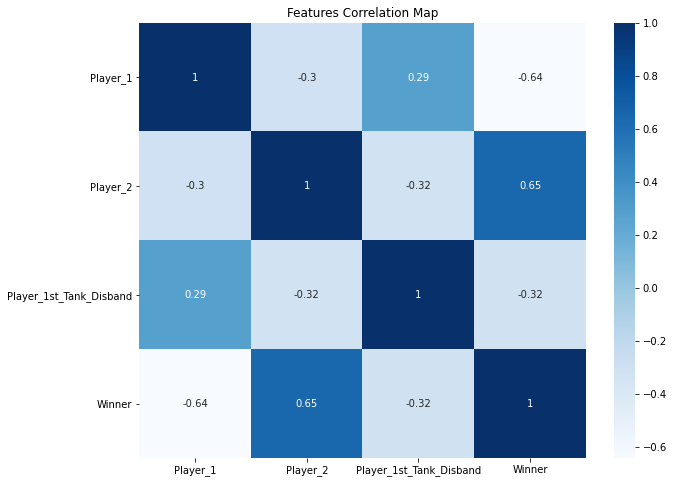

In [5]:
# using Pearson Correlation
plt.figure(figsize=(10,8))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.title("Features Correlation Map")
plt.show()

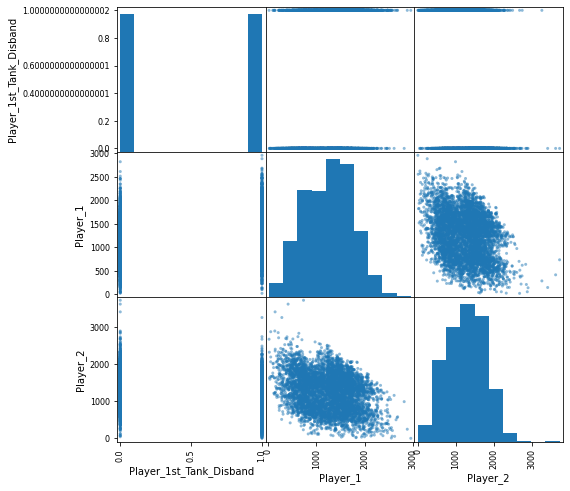

In [6]:
from pandas.plotting import scatter_matrix
feature_cols = ['Player_1st_Tank_Disband', 'Player_1', 'Player_2']
scatter_matrix(data[feature_cols], figsize=(8,8));

In [7]:
# Total number of matches
n_matches = data.shape[0]

# Calculate number of features. '-1' because one is saved as target
n_features = data.shape[1] - 1

# Calculate matches won by Player 0
n_player0wins = len(data[data.Winner == 0])

# n_strikers = len(data[data.groupLostUnitType == 1])
# n_strikers = len(data[(data.groupLostUnitType == 1) & (data.winner == 0)])
# n_tanks = len(data[data.groupLostUnitType == 2])
# n_controllers = len(data[data.groupLostUnitType == 3])

player1 = len(data[(data.Player_1st_Tank_Disband == 0) & (data.Winner == 1)])
player2 = len(data[(data.Player_1st_Tank_Disband == 1) & (data.Winner == 1)])

# Calculate win rate for Player 0
win_rate = (float(n_player0wins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by Player 1: {}".format(n_player0wins))
print("Win rate of Player 0: {:.2f}%".format(win_rate))
print('')
# print('Num of Strikers Lost First: {}\nPercent of Strikers: {:.2f}'.format(n_strikers,(n_strikers/n_matches)))
# print('Num of Tanks Lost First: {}\nPercent of Tanks: {:.2f}'.format(n_tanks,(n_tanks/n_matches)))
# print('Num of Controllers Lost First: {}\nPercent of Controllers: {:.2f}'.format(n_controllers,(n_controllers/n_matches)))
# print('')
print("P1 Lost Unit: {}, {:.2f}%".format(player1, (player1/n_matches)))
print("P2 Lost Unit: {}, {:.2f}%".format(player2, (player2/n_matches)))

Total number of matches: 5823
Number of features: 3
Number of matches won by Player 1: 2900
Win rate of Player 0: 49.80%

P1 Lost Unit: 1929, 0.33%
P2 Lost Unit: 994, 0.17%


In [8]:
feature_cols = ['Player_1st_Tank_Disband', 'Player_1', 'Player_2']
X = data[feature_cols]
y = data['Winner']

# standardizing the data
from sklearn.preprocessing import scale

X = pd.DataFrame(scale(X), columns=feature_cols, index=data.index)

X.head()

,Player_1st_Tank_Disband,Player_1,Player_2
0,1.002235,-0.678536,-0.334157
1,1.002235,0.577474,0.982629
2,1.002235,0.236759,-0.891948
3,1.002235,-0.807565,-1.244551
4,1.002235,0.051280,-0.340133


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4, stratify = y)

In [0]:
# for measuring training time
from time import time 
# for measuring accuracy. Considers both precision and recall to compute score
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))
    
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label=0), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    # print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

Accuracy is important as it 

$Accuracy = \frac{Number of correct Predictions}{Total number of predictions}$

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

where *TP* = True Positive, *TN* = True Negative, *FP* = False Negative, *FN* = False Negative

In [12]:
# Initialize the four models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = KNeighborsClassifier(n_neighbors=10)
clf_C = RandomForestClassifier(max_depth = 2, random_state=0)
clf_D = SVC(random_state = 912, kernel='rbf')

# Boosting refers to this general problem of producing a very accurate prediction rule 
# by combining rough and moderately inaccurate rules-of-thumb
clf_E = xgb.XGBClassifier(seed = 2)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_E, X_train, y_train, X_test, y_test)

Training a LogisticRegression using a training set size of 4658. . .
Trained model in 0.0205 seconds
Made predictions in 0.0008 seconds.
F1 score and accuracy score for training set: 0.9994 , 0.9994.
Made predictions in 0.0007 seconds.
F1 score and accuracy score for test set: 1.0000 , 1.0000.

Training a KNeighborsClassifier using a training set size of 4658. . .
Trained model in 0.0050 seconds
Made predictions in 0.1763 seconds.
F1 score and accuracy score for training set: 0.9948 , 0.9948.
Made predictions in 0.0290 seconds.
F1 score and accuracy score for test set: 0.9966 , 0.9966.

Training a RandomForestClassifier using a training set size of 4658. . .
Trained model in 0.1904 seconds
Made predictions in 0.0319 seconds.
F1 score and accuracy score for training set: 0.9390 , 0.9390.
Made predictions in 0.0125 seconds.
F1 score and accuracy score for test set: 0.9338 , 0.9339.

Training a SVC using a training set size of 4658. . .
Trained model in 0.0720 seconds
Made predictions in 

### **Grid Search Cross Validation**

We perform Grid Search CV, which is the process of performing hyper parameter tuning in order to determine the optimal values for a given model

In [0]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def train_grid_search(clf, params, X_train, y_train, X_test, y_test, kfolds):
    
    # Indicate the classifier and the training set size
    model_name = clf.__class__.__name__
    print("Training a {}. . .".format(model_name))
    # Make an f1 scoring function using 'make_scorer'
    f1_scorer = make_scorer(f1_score,pos_label=0)

    # Perform grid search on the classifier using the f1_scorer as the scoring method
    grid_search = GridSearchCV(
                          clf, 
                          scoring = f1_scorer, 
                          param_grid=params,
                          cv = kfolds
                  )
    # Fit the grid search object to the training data and find the optimal parameters
    grid_search = grid_search.fit(X_train,y_train)

    # Get the estimator
    grid_search_best = grid_search.best_estimator_
    #print(log_reg_best)

    # Report the final F1 score for training and testing after parameter tuning
    f1, acc = predict_labels(grid_search_best, X_train, y_train)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
        
    f1, acc = predict_labels(grid_search_best, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

    return model_name, grid_search, grid_search_best

def log_reg_gridsearch(X_train, y_train, X_test, y_test, nfolds):
    paramsLogReg = {
        'penalty' : ['l1', 'l2'],
        'C': [0.001,0.009,0.01,0.09,1,5,10,25],
        'solver' : ['liblinear'],
        'max_iter' : [100, 1000,2500, 5000]
    }

    # Initialize the classifier
    clf = LogisticRegression()

    return train_grid_search(clf, paramsLogReg, X_train, y_train, X_test, y_test, nfolds)


def knn_gridsearch(X_train, y_train, X_test, y_test, nfolds):
    paramsKNN = { 
        'n_neighbors' : [3,5,11,19],
        'weights' : ['uniform','distance'],
        'metric' : ['euclidean', 'manhattan']
    }

    # Initialize the classifier
    clf = KNeighborsClassifier()
    return train_grid_search(clf, paramsKNN, X_train, y_train, X_test, y_test, nfolds)

def random_forest_gridsearch(X_train, y_train, X_test, y_test, nfolds):
    # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    n_estimators = [50, 150, 250]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    paramsRandForest = {
      'n_estimators': [50, 150, 250],
      'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
      'min_samples_split': [2, 4, 6]
    }

    # Initialize the classifier
    clf = RandomForestClassifier(random_state=1)

    return train_grid_search(clf, paramsRandForest, X_train, y_train, X_test, y_test, nfolds)


def svm_gridsearch(X_train, y_train, X_test, y_test, nfolds):
    paramsSVM = {
      'C': [0.1,1, 10, 100], 
      'gamma': [1,0.1,0.01,0.001],
      'kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Initialize the classifier
    clf = SVC()

    return train_grid_search(clf, paramsSVM, X_train, y_train, X_test, y_test, nfolds)


def xg_boost_gridsearch(X_train, y_train, X_test, y_test, nfolds):
    paramsXGB = {
      'learning_rate' : [0.1, 0.01, 0.05],
      'n_estimators' : range(60, 220, 40),
      'max_depth': range (2, 10, 1),
      'min_child_weight': [1,2,3,4,5],
      'gamma':[0.4],
      'subsample' : [0.8],
      'colsample_bytree' : [0.8],
      'scale_pos_weight' : [1],
      'reg_alpha':[1e-5]
    }

    # Initialize the classifier
    clf = xgb.XGBClassifier(seed=2)

    return train_grid_search(clf, paramsXGB, X_train, y_train, X_test, y_test, nfolds)

We perform Grid Search CV on the model that produced the highest accuracy to see if we can get optimized solution with tuned parameters

In [14]:
kfolds = 10
name, log_reg, log_reg_best = log_reg_gridsearch(X_train, y_train, X_test, y_test, kfolds)
print(log_reg_best.get_params)

Training a LogisticRegression. . .
Made predictions in 0.0006 seconds.
F1 score and accuracy score for training set: 0.9994 , 0.9994.
Made predictions in 0.0009 seconds.
F1 score and accuracy score for test set: 0.9991 , 0.9991.
<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)>


In [0]:
from sklearn.metrics import plot_confusion_matrix

def display_confusion_matrix(name, clf, X_test, y_test):
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    title = "Confusion matrix using {}".format(name)

    # for title, normalize in titles_options:
    disp = plot_confusion_matrix(
                  clf, X_test, y_test,
                  cmap=plt.cm.Blues,
                  values_format = '.5g',
                  normalize=None,
                  display_labels = ['Player 1', 'Player 2']
          )
    disp.ax_.set_title(title)

### Display Confusion Matrix

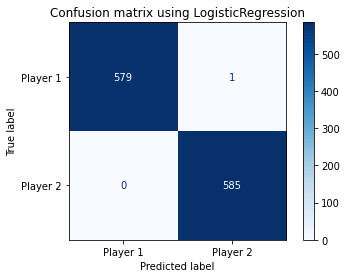

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

display_confusion_matrix(name, log_reg, X_test, y_test)

In [17]:
tn, tp, fn, fp = 585, 579, 1, 0
accuracy = (tp + tn)/(tp + tn + fn + fp)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = 2 * (precision * recall)/(precision + recall)

print('Accuracy: {:.4f}'.format(accuracy))
print('Error: {:.4f}'.format(1-accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

Accuracy: 0.9991
Error: 0.0009
Precision: 1.0000
Recall: 0.9983
F1 Score: 0.9991


###Determine accuracy based on Voting Ensembling, using the hyperparameters for each model from Grid Search

In [18]:
from sklearn.ensemble import VotingClassifier

# create a dictionary of the models
name, knn, knn_best = knn_gridsearch(X_train, y_train, X_test, y_test, kfolds)
print('')
name, rf, rf_best = random_forest_gridsearch(X_train, y_train, X_test, y_test, kfolds)
print('')
name, svm, svm_best = svm_gridsearch(X_train, y_train, X_test, y_test, kfolds)
print('')
name, xg_boost, xgb_best = xg_boost_gridsearch(X_train, y_train, X_test, y_test, kfolds)

estimators = [('log_reg', log_reg_best),('knn', knn_best), ('svm', svm_best)]

# create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

Training a KNeighborsClassifier. . .
Made predictions in 0.0296 seconds.
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0083 seconds.
F1 score and accuracy score for test set: 0.9983 , 0.9983.

Training a RandomForestClassifier. . .
Made predictions in 0.0482 seconds.
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0210 seconds.
F1 score and accuracy score for test set: 0.9957 , 0.9957.

Training a SVC. . .
Made predictions in 0.0039 seconds.
F1 score and accuracy score for training set: 0.9989 , 0.9989.
Made predictions in 0.0015 seconds.
F1 score and accuracy score for test set: 0.9991 , 0.9991.

Training a XGBClassifier. . .
Made predictions in 0.0301 seconds.
F1 score and accuracy score for training set: 0.9994 , 0.9994.
Made predictions in 0.0082 seconds.
F1 score and accuracy score for test set: 0.9922 , 0.9923.


0.9991416309012876

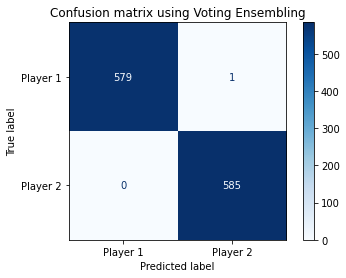

In [19]:
# fit model to training data
ensemble.fit(X_train, y_train)

name = "Voting Ensembling"

display_confusion_matrix(name, ensemble, X_test, y_test)
# test our model on the test data
ensemble.score(X_test, y_test)

In [20]:
tn, tp, fn, fp = 585, 579, 1, 0

accuracy = (tp + tn)/(tp + tn + fn + fp)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = 2 * (precision * recall)/(precision + recall)

print('Accuracy: {:.4f}'.format(accuracy))
print('Error: {:.4f}'.format(1-accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

Accuracy: 0.9991
Error: 0.0009
Precision: 1.0000
Recall: 0.9983
F1 Score: 0.9991


In [0]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("F1 Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='f1',
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


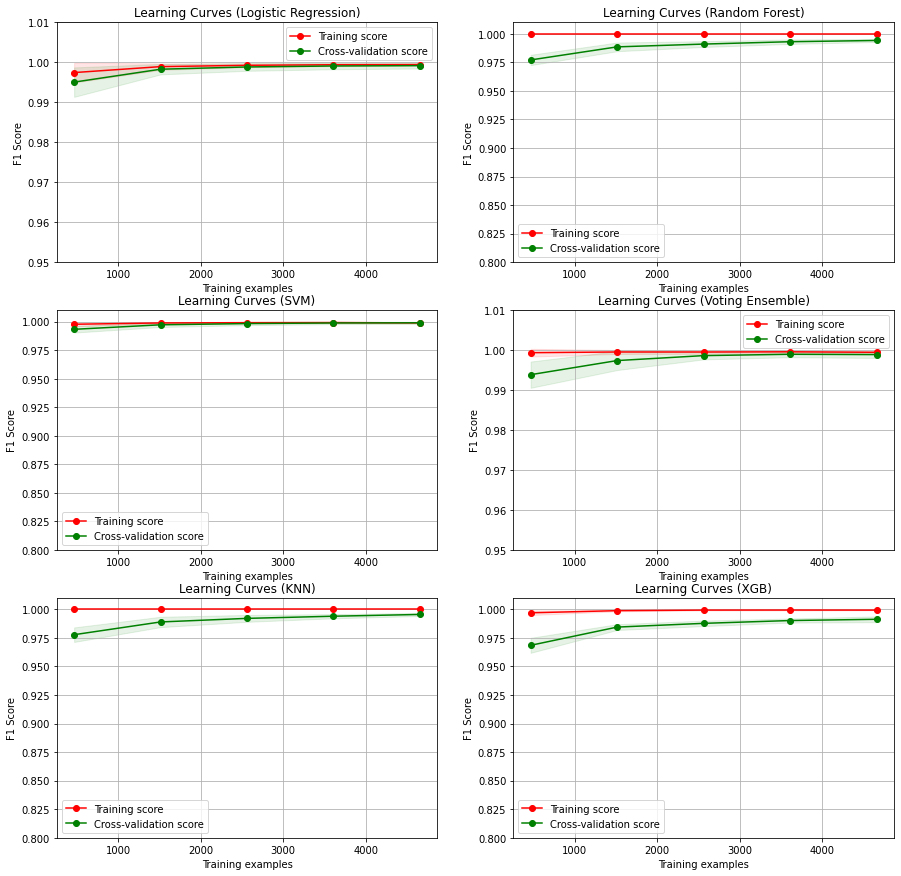

In [22]:
from sklearn.model_selection import ShuffleSplit

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
#fig, axes = plt.subplots(1, 2, figsize=(15, 5))

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = log_reg_best
plot_learning_curve(estimator, title, X, y, axes=axes[0,0], ylim=(0.95, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = rf_best
plot_learning_curve(estimator, title, X, y, axes=axes[0,1], ylim=(0.8, 1.01),
                    cv=cv, n_jobs=-1)

title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svm_best
plot_learning_curve(estimator, title, X, y, axes=axes[1,0], ylim=(0.8, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (Voting Ensemble)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = ensemble
plot_learning_curve(estimator, title, X, y, axes=axes[1,1], ylim=(0.95, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (KNN)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = knn_best
plot_learning_curve(estimator, title, X, y, axes=axes[2,0], ylim=(0.8, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (XGB)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = xgb_best
plot_learning_curve(estimator, title, X, y, axes=axes[2,1], ylim=(0.8, 1.01),
                    cv=cv, n_jobs=-1)

plt.show();